In [ ]:
# !pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [ ]:
# !pip install tf-keras

# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here : https://arxiv.org/abs/1612.05251

If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c48c3e77-7277-d77d-72b9-74c24c833420)


## Get Data

Since we'll be replicationg the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub : https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced  y "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number' : 0,
  'target' : 'BACKGROUND',
  'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines' : 11},
  ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filenames):
  """
  Return a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filenames) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstract

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through eeach line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract ?
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract ?
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 342 ms, sys: 72.9 ms, total: 415 ms
Wall time: 417 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it ?

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

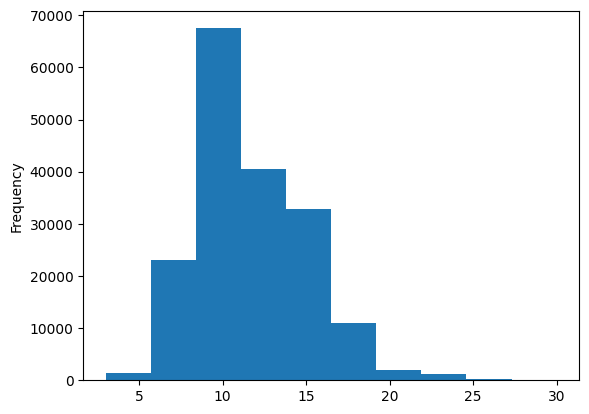

In [ ]:
# Let's check the length of different line
train_df.total_lines.plot.hist()

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_Hot = one_hot.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


In [ ]:
val_df.target.value_counts()

,count
target,
METHODS,9964
RESULTS,9841
CONCLUSIONS,4582
BACKGROUND,3449
OBJECTIVE,2376


In [ ]:
test_df.target.value_counts()

,count
target,
METHODS,9897
RESULTS,9713
CONCLUSIONS,4571
BACKGROUND,3621
OBJECTIVE,2333


### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_le = le.fit_transform(train_df["target"].to_numpy())
val_labels_le = le.transform(val_df["target"].to_numpy())
test_labels_le = le.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_le

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_class = len(le.classes_)
class_name = le.classes_
num_class, class_name

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different model and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_le)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_le)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_predict = model_0.predict(val_sentences)
baseline_predict

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script. https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-07-16 14:58:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-16 14:58:02 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Calculate baseline results
from helper_functions import calculate_results

baseline_results = calculate_results(y_true=val_labels_le,
                                    y_pred=baseline_predict)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# How long is each sentence on average ?
sen_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sen_lens)
avg_sent_len

26.338269273494777

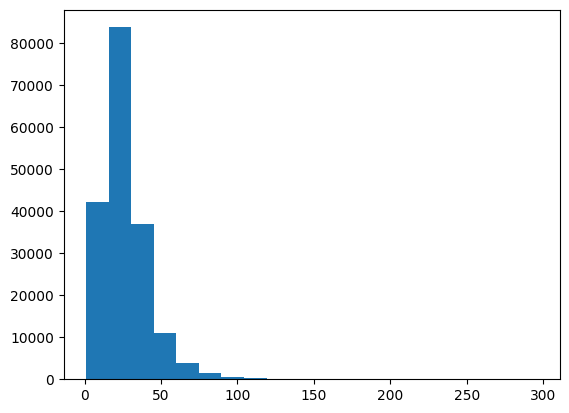

In [ ]:
# What's the distribution look like ?
import matplotlib.pyplot as plt
plt.hist(sen_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sen_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
np.max(sen_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
# How many words are in our vocab ? (taken from table 2 in : https://arxiv.org/pdf/1710.06071.pdf)
max_token = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_token,# number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
training_sample = random.choice(train_sentences)
print(f"Text :\n{training_sample}")
print(f"\nLength of Text : {len(training_sample)}")
print(f"\nVectorize Text : {text_vectorizer(training_sample)}")

Text :
testosterone administration in hysterectomized women with or without oophorectomy for @ weeks was associated with dose and concentration-dependent gains in several domains of sexual function , lean body mass , chest-press power , and loaded stair-climb power .

Length of Text : 260

Vectorize Text : [ 2105   288     5 30796    90     7    16   159 14657    11    53    10
    81     7   131     3 17369  2187     5   881  1731     4   809   149
  2880   239   385 40325   817     3  5345 19551   817     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = [str(word) for word in text_vectorizer.get_vocabulary()]
print(f"Number of words in vocab : {len(rct_20k_text_vocab)}")
print(f"Most Common Vocabulary : {rct_20k_text_vocab[:5]}")
print(f"Least Common Vocabulary : {rct_20k_text_vocab[-5:]}")

Number of words in vocab : 64841
Most Common Vocabulary : ['', '[UNK]', 'the', 'and', 'of']
Least Common Vocabulary : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get th config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), #length of vocabulary
                                        output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                                        mask_zero=True, # use masking to handle variable sequence lengths (save_space))
                                        name="token_embedding")

In [ ]:
print(f"Sentence before vectorization :\n{training_sample}\n")
vectorized_sentence = text_vectorizer([training_sample])
print(f"Text after vectorization (before embedding) :\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding :\n{embedded_sentence}\n")
print(f"Embedded sentence shape : {embedded_sentence.shape}")

Sentence before vectorization :
testosterone administration in hysterectomized women with or without oophorectomy for @ weeks was associated with dose and concentration-dependent gains in several domains of sexual function , lean body mass , chest-press power , and loaded stair-climb power .

Text after vectorization (before embedding) :
[[ 2105   288     5 30796    90     7    16   159 14657    11    53    10
     81     7   131     3 17369  2187     5   881  1731     4   809   149
   2880   239   385 40325   817     3  5345 19551   817     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding :
[[[ 0.00167609  0.02340753 -0.03109994 ... -0.04434439 -0.03081897
   -0.04985298]
  [ 0.03533674  0.0098827   0.00490098 ...  0.03234775  0.00052222
   -0.03214067]
  [-0.00810704 -0.00674927 -0.01505572 ...  0.01981119  0.04472296
    0.03476789]
  ...
  [ 0.00748824  0.04927221 -0.02568

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the Tensorflow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_Hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched dataasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)

vectorized = text_vectorizer(inputs) # vectorize text inputs

embedded = token_embed(vectorized) # create embedding

x = layers.Conv1D(64, 5, activation="relu", padding="same")(embedded)

x = layers.GlobalAveragePooling1D()(x) # condese the output of our feature vector from conv layer

outputs = layers.Dense(num_class, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 68s 120ms/step - loss: 0.9123 - accuracy: 0.6437 - val_loss: 0.6797 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 77s 137ms/step - loss: 0.6582 - accuracy: 0.7565 - val_loss: 0.6324 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 60s 107ms/step - loss: 0.6182 - accuracy: 0.7722 - val_loss: 0.5975 - val_accuracy: 0.7826


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5995 - accuracy: 0.7863


[0.5994881987571716, 0.786310076713562]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.3178332e-01, 1.4956635e-01, 7.9308689e-02, 3.0935287e-01,
         2.9988704e-02],
        [4.6002513e-01, 2.8160685e-01, 1.4447604e-02, 2.3578605e-01,
         8.1343101e-03],
        [1.7980897e-01, 7.4390918e-03, 2.2238104e-03, 8.1049508e-01,
         3.3004333e-05],
        ...,
        [5.3406116e-06, 5.8225921e-04, 6.5809878e-04, 4.0782493e-06,
         9.9875021e-01],
        [5.5231504e-02, 4.5969382e-01, 1.0319319e-01, 7.2568074e-02,
         3.0931342e-01],
        [1.5336825e-01, 6.9378549e-01, 3.9059084e-02, 4.9747650e-02,
         6.4039573e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pre probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
val_labels_le

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_le,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.63100754667019,
 'precision': 0.7827282630821891,
 'recall': 0.786310075466702,
 'f1': 0.7837215254084645}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE) : https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
import tf_keras as keras

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_sample_sentence = random.choice(train_sentences)
print(f"Random sentence :\n{random_sample_sentence}\n")
embed_sentence = tf_hub_embedding_layer([random_sample_sentence])
print(f"Sentence after embedding:\n{embed_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(embed_sentence[0])}")

Random sentence :
to explore the efficacy and safety of recombinant tissue plasminogen activator ( rt-pa ) in thrombolytic therapy of vena caval thromboembolism .

Sentence after embedding:
[ 0.06402523  0.04209118  0.04223262 -0.07219107 -0.06557301 -0.05638796
  0.04900062 -0.04164623  0.05014876 -0.02581049  0.0950979  -0.00873165
 -0.04113853  0.05769564  0.06091023 -0.0732634  -0.09333742 -0.07962228
 -0.06719155  0.00942883  0.00098969 -0.00720049 -0.01640044 -0.05247368
  0.03216387  0.02429302  0.06047783  0.00515275  0.01104074  0.01965045]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
import tf_keras as keras
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)

x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)
# Note : you could add more layers here if you wanted to
outputs = tf.keras.layers.Dense(num_class, activation="softmax")(x) # create the output layer

model_2 = tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name="USE_Embedding_model")
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "USE_Embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 0.9157 - accuracy: 0.6511 - val_loss: 0.7955 - val_accuracy: 0.6922
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7685 - accuracy: 0.7032 - val_loss: 0.7546 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7516 - accuracy: 0.7130 - val_loss: 0.7380 - val_accuracy: 0.7114


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.7399 - accuracy: 0.7143


[0.739883542060852, 0.7142857313156128]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[4.3402287e-01, 3.4304652e-01, 2.3737184e-03, 2.1199891e-01,
        8.5580656e-03],
       [3.3111075e-01, 5.0757319e-01, 4.4660415e-03, 1.5376829e-01,
        3.0816535e-03],
       [2.4957937e-01, 1.5934218e-01, 1.7365115e-02, 5.3847772e-01,
        3.5235610e-02],
       ...,
       [1.9824284e-03, 6.0656057e-03, 5.1005676e-02, 8.9703401e-04,
        9.4004917e-01],
       [3.9268243e-03, 4.6029128e-02, 1.9229223e-01, 1.4239399e-03,
        7.5632787e-01],
       [1.4858717e-01, 2.6269528e-01, 5.1738030e-01, 7.0796316e-03,
        6.4257607e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_le,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.42857142857143,
 'precision': 0.7141909168806815,
 'recall': 0.7142857142857143,
 'f1': 0.7112551638517237}

## Model 3: Conv 1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(training_sample)

't e s t o s t e r o n e   a d m i n i s t r a t i o n   i n   h y s t e r e c t o m i z e d   w o m e n   w i t h   o r   w i t h o u t   o o p h o r e c t o m y   f o r   @   w e e k s   w a s   a s s o c i a t e d   w i t h   d o s e   a n d   c o n c e n t r a t i o n - d e p e n d e n t   g a i n s   i n   s e v e r a l   d o m a i n s   o f   s e x u a l   f u n c t i o n   ,   l e a n   b o d y   m a s s   ,   c h e s t - p r e s s   p o w e r   ,   a n d   l o a d e d   s t a i r - c l i m b   p o w e r   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
import matplotlib.pyplot as plt
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = int(np.mean(char_lens))
mean_char_len

149

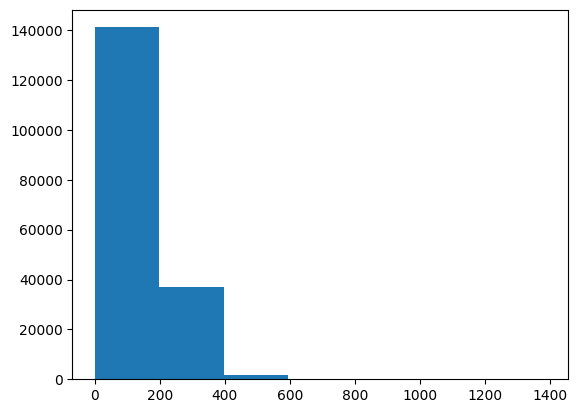

In [ ]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV tokens (OOV = Out Of Vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer"
                                    # standardization="None" set standardization to "None" if you want to leave punctuation in
                                    )

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = [str(char) for char in char_vectorizer.get_vocabulary()]
print(f"Number of different characters in character vocab : {len(char_vocab)}")
print(f"Most common char in text : {char_vocab[:5]}")
print(f"Least common char in text : {char_vocab[-5:]}")

Number of different characters in character vocab : 28
Most common char in text : ['', '[UNK]', 'e', 't', 'i']
Least common char in text : ['k', 'x', 'z', 'q', 'j']


> `.split()` akan memisahkan string berdasarkan spasi, dan hasilnya adalah list karakter:

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text :\n {random_train_chars}")
print(f"\nLength of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized text :\n{vectorized_chars}")
print(f"\nLength of vectorized chars : {len(vectorized_chars[0])}")

Charified text :
 d e f e r i p r o n e   i s   a   h i g h l y   e f f i c a c i o u s   a n d   s a f e   c h e l a t i o n   t h e r a p y   f o r   p a t i e n t s   w i t h   t h a l a s s e m i a   m a j o r   w h o   a r e   n o n - c o m p l i a n t   t o   d e f e r r i o x a m i n e   .

Length of random_train_chars : 121

Vectorized text :
[[10  2 17  2  8  4 14  8  7  6  2  4  9  5 13  4 18 13 12 19  2 17 17  4
  11  5 11  4  7 16  9  5  6 10  9  5 17  2 11 13  2 12  5  3  4  7  6  3
  13  2  8  5 14 19 17  7  8 14  5  3  4  2  6  3  9 20  4  3 13  3 13  5
  12  5  9  9  2 15  4  5 15  5 27  7  8 20 13  7  5  8  2  6  7  6 11  7
  15 14 12  4  5  6  3  3  7 10  2 17  2  8  8  4  7 24  5 15  4  6  2  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified Text :\n{random_train_chars}\n")
embedded_example_char = char_embed(char_vectorizer([random_train_chars]))
print(f"Character embedding shape : {embedded_example_char.shape}\n")
print(f"Embedded chars (after vectorization and embedding) :\n{embedded_example_char}")

Charified Text :
d e f e r i p r o n e   i s   a   h i g h l y   e f f i c a c i o u s   a n d   s a f e   c h e l a t i o n   t h e r a p y   f o r   p a t i e n t s   w i t h   t h a l a s s e m i a   m a j o r   w h o   a r e   n o n - c o m p l i a n t   t o   d e f e r r i o x a m i n e   .

Character embedding shape : (1, 290, 25)

Embedded chars (after vectorization and embedding) :
[[[-0.02984743  0.00831217 -0.0073389  ... -0.00265505 -0.02506553
    0.03947426]
  [ 0.02696813  0.04701208  0.04445429 ... -0.01220944  0.03478486
    0.00780869]
  [-0.0466336   0.01377567 -0.03875854 ... -0.02701672 -0.0224502
    0.00114304]
  ...
  [-0.01419365 -0.02265115  0.03029438 ...  0.04576384 -0.04344307
    0.02815871]
  [-0.01419365 -0.02265115  0.03029438 ...  0.04576384 -0.04344307
    0.02815871]
  [-0.01419365 -0.02265115  0.03029438 ...  0.04576384 -0.04344307
    0.02815871]]]


In [ ]:
len([huruf for huruf in random_train_chars if huruf != " "])

121

In [ ]:
len([huruf for huruf in vectorized_chars[0] if huruf != 0])

119

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_class, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_Hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 13ms/step - loss: 1.2788 - accuracy: 0.4869 - val_loss: 1.0609 - val_accuracy: 0.5691
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 1.0055 - accuracy: 0.5976 - val_loss: 0.9352 - val_accuracy: 0.6267
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.9216 - accuracy: 0.6422 - val_loss: 0.8673 - val_accuracy: 0.6566


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8803 - accuracy: 0.6610


[0.8802793025970459, 0.6609625220298767]

In [ ]:
# Make a predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:5]

945/945 [==============================] - 4s 4ms/step


array([[0.1312004 , 0.2081745 , 0.05097742, 0.60136014, 0.00828759],
       [0.12936305, 0.6537498 , 0.02020231, 0.15661065, 0.04007419],
       [0.15432978, 0.3085235 , 0.1583606 , 0.33246234, 0.04632379],
       [0.0103823 , 0.01020541, 0.9498944 , 0.00817104, 0.02134681],
       [0.02883891, 0.07208692, 0.70783776, 0.01753311, 0.17370334]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 0])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_le,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.09625314444591,
 'precision': 0.6543427547408754,
 'recall': 0.6609625314444592,
 'f1': 0.6484827184430968}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectorizers = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorizers)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_class, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary
model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

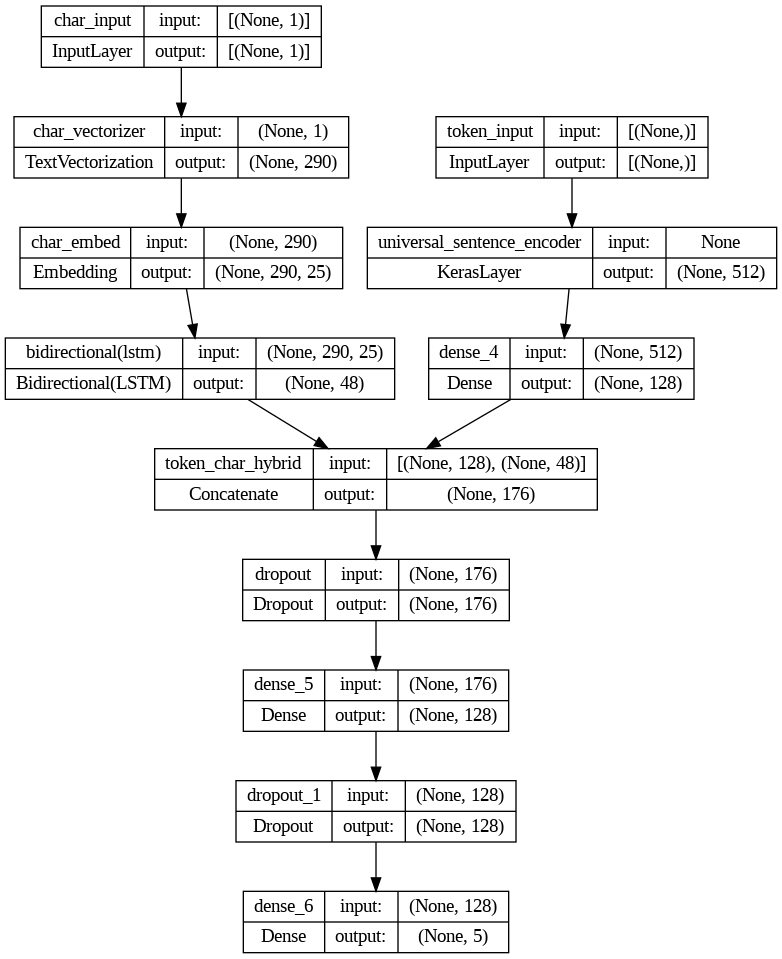

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want try this
                metrics=["accuracy"])

>Note : if u using multimodal model u should make sure you're dataset sequence were same position with tf.keras.Model

example :
`model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)`

and your input data should be (sentences, char)

### Combining token and character data into a tf.data.Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make label
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_label)) # combine data and label

# Prefetch and batch train_data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make label
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_label)) # combine data and label

# Prefetch and batch val_data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 159s 275ms/step - loss: 0.9829 - accuracy: 0.6118 - val_loss: 0.7647 - val_accuracy: 0.7064
Epoch 2/3
562/562 [==============================] - 153s 273ms/step - loss: 0.7962 - accuracy: 0.6949 - val_loss: 0.7200 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 163s 290ms/step - loss: 0.7696 - accuracy: 0.7057 - val_loss: 0.6899 - val_accuracy: 0.7407


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 65s 69ms/step - loss: 0.6937 - accuracy: 0.7339


[0.6936728358268738, 0.7339136600494385]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

945/945 [==============================] - 65s 68ms/step


array([[4.05521214e-01, 3.86905521e-01, 5.28258411e-03, 1.93698525e-01,
        8.59216321e-03],
       [3.46042603e-01, 4.98540074e-01, 3.79804592e-03, 1.48656592e-01,
        2.96273199e-03],
       [2.81386614e-01, 1.95706353e-01, 4.81452644e-02, 4.03364182e-01,
        7.13976398e-02],
       [2.04461347e-02, 2.47778874e-02, 8.12348723e-01, 8.47285893e-03,
        1.33954346e-01],
       [3.24731879e-02, 1.28393456e-01, 5.83084464e-01, 1.60683710e-02,
        2.39980444e-01],
       [6.29799557e-04, 2.46534427e-03, 6.99186325e-01, 1.69000923e-04,
        2.97549427e-01],
       [1.33786455e-03, 1.17167914e-02, 4.89820629e-01, 4.38240502e-04,
        4.96686518e-01],
       [2.57289479e-03, 3.38399969e-02, 4.70663130e-01, 6.32282870e-04,
        4.92291689e-01],
       [3.46019806e-04, 1.10374466e-02, 4.25837673e-02, 1.68684128e-04,
        9.45864141e-01],
       [1.62693247e-01, 6.20299637e-01, 3.41002755e-02, 6.95037246e-02,
        1.13403074e-01]], dtype=float32)

In [ ]:
# Format pred probs into pre labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_le,
                                    y_pred=model_4_preds)

In [ ]:
model_4_results

{'accuracy': 73.39136766847611,
 'precision': 0.7368693847292571,
 'recall': 0.733913676684761,
 'f1': 0.7305548671392619}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


>🔑**Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available

### Create positional embeddings

In [ ]:
# How many different line numbers are there ?
train_df.line_number.value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

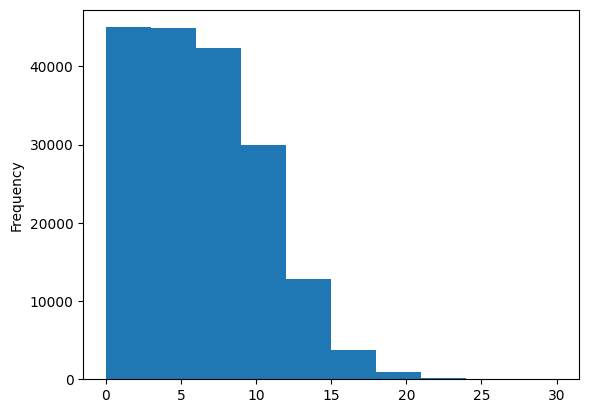

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numnbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there ?
train_df.total_lines.value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

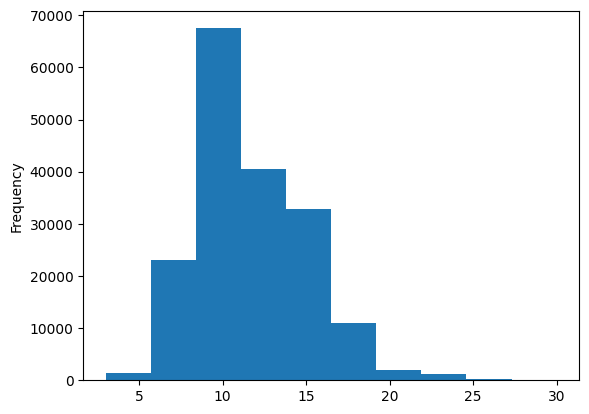

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the covarage of a "total_lines" value of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_df_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_df_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_df_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_df_total_lines_one_hot[:10], train_df_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                                  outputs=y)

# 5 combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_class, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribid_embedding_model")

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

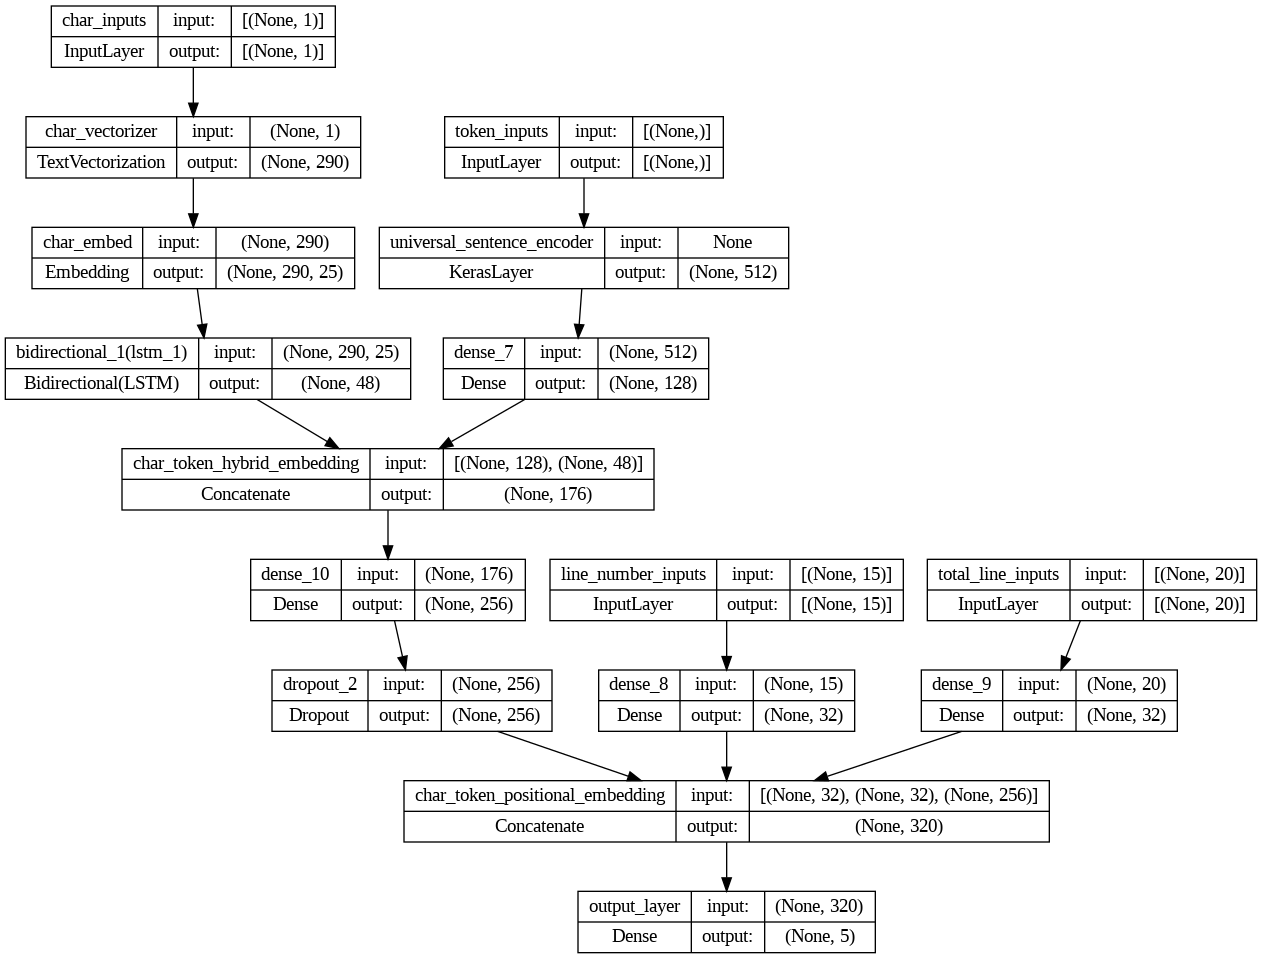

In [ ]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing ?

For example, if our model gets too confident on a single class (e.g its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 0.1, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

>📖**Resource**: For more on label smoothing, see this blog post from PyImageSearch:
https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_df_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_df_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 226s 394ms/step - loss: 1.0905 - accuracy: 0.7289 - val_loss: 0.9838 - val_accuracy: 0.8055
Epoch 2/3
562/562 [==============================] - 165s 293ms/step - loss: 0.9669 - accuracy: 0.8146 - val_loss: 0.9514 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 155s 276ms/step - loss: 0.9503 - accuracy: 0.8216 - val_loss: 0.9381 - val_accuracy: 0.8358


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs[:5]

945/945 [==============================] - 51s 53ms/step


array([[0.51745045, 0.1131958 , 0.00951716, 0.34372774, 0.01610881],
       [0.57487476, 0.10791077, 0.03062931, 0.27879915, 0.00778605],
       [0.25859073, 0.11343496, 0.10506868, 0.44727102, 0.07563464],
       [0.03807894, 0.05868214, 0.7251366 , 0.03746918, 0.14063312],
       [0.04384946, 0.05196977, 0.74306446, 0.04289159, 0.11822467]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_le,
                                    y_pred=model_5_preds)

In [ ]:
model_5_results

{'accuracy': 83.18879915265457,
 'precision': 0.8308727455961037,
 'recall': 0.8318879915265457,
 'f1': 0.8312455582150636}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embedding" : model_1_results,
                                  "model_2_pretrained_token_embedding" : model_2_results,
                                  "model_3_custom_char_embedding" : model_3_results,
                                  "model_4_hybrid_char_token_embedding" : model_4_results,
                                  "model_5_pos_char_token_embedding" : model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.631008,0.782728,0.786310,0.783722
model_2_pretrained_token_embedding,71.428571,0.714191,0.714286,0.711255
model_3_custom_char_embedding,66.096253,0.654343,0.660963,0.648483
model_4_hybrid_char_token_embedding,73.391368,0.736869,0.733914,0.730555
model_5_pos_char_token_embedding,83.188799,0.830873,0.831888,0.831246


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

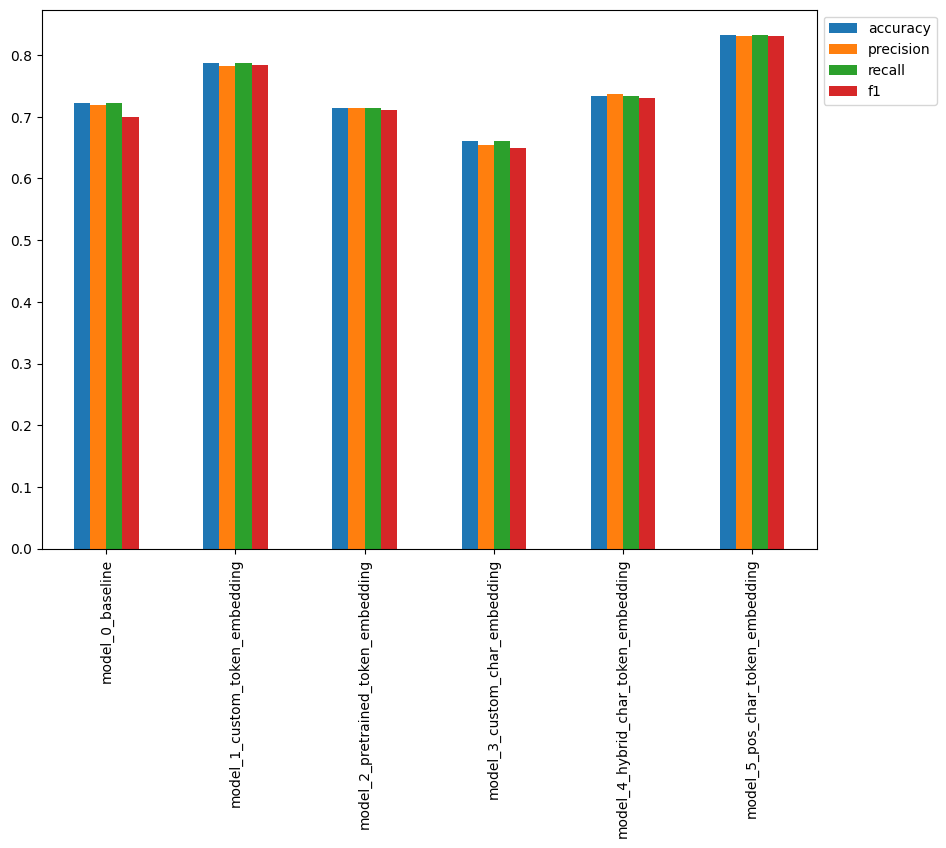

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

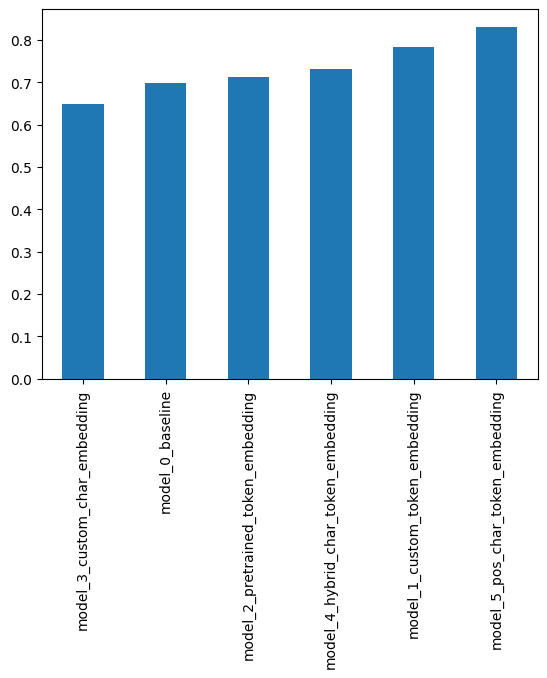

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar");

## Save and load model

In [ ]:
# Save the best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

/usr/local/lib/python3.11/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.GlorotUniform'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Orthogonal'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Zeros'>,

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on the validation dataset
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 71s 71ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(y_true=val_labels_le,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.18879915265457,
 'precision': 0.8308727455961037,
 'recall': 0.8318879915265457,
 'f1': 0.8312455582150636}

In [ ]:
assert model_5_results == loaded_model_results